## Capstone Project - Winonsin Breast Cancer Diagnosis Deep Learning Revisited






#### Import necessary libraries

In [774]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
# from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

#### Load in WBCD dataset

In [775]:
# Load the Boston housing dataset
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.csv', na_values='?', header=None, index_col=['ID'], names = headers)
data = data.reset_index(drop=True)

#### Handle missing data
* There are 16 Bare Nuclei entries missing and marked as "?". Those question marks were replaced as NaN during data loading. 
* All the NaN entries are filled with zero.

In [776]:
data = data.fillna(0)

In [777]:
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.463519,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.640708,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


#### Define a data generation function with random noise

In [778]:
def generateData(data):
    # make a copy of data
    data2 = data

    # separate labels from features
    diagnosis2 = data2['Diagnosis'] # labels
    features2 = data2.drop(['Diagnosis'], axis = 1)
    features2_headers = ["CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]

    mean, sigma = 0, 0.1 
    # creating a noise with the same dimension as the dataset 
    noise = np.random.normal(mean, sigma, features2.shape) 
    features2 = features2.apply(pd.to_numeric, errors='ignore')
    features2_with_noise = features2.add(pd.DataFrame(noise, columns = features2_headers), fill_value=0)
    data2 = pd.concat([features2_with_noise, pd.DataFrame(diagnosis2)], axis = 1)
    
    return data2

#### Add the new generated dataset into the existing dataset

In [779]:
data_copy = data;

new_data = generateData(data_copy)
data = data.append(new_data, ignore_index=True)

print("data size = ", data.shape[0])

('data size = ', 1398)


#### Scale dataset to the range of [0, 1]

In [780]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ["Diagnosis","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]
data[numerical] = scaler.fit_transform(data[numerical])

#### Separate Labels/Classes from Features

In [781]:
diagnosis = data['Diagnosis']
features = data.drop(['Diagnosis'], axis = 1)

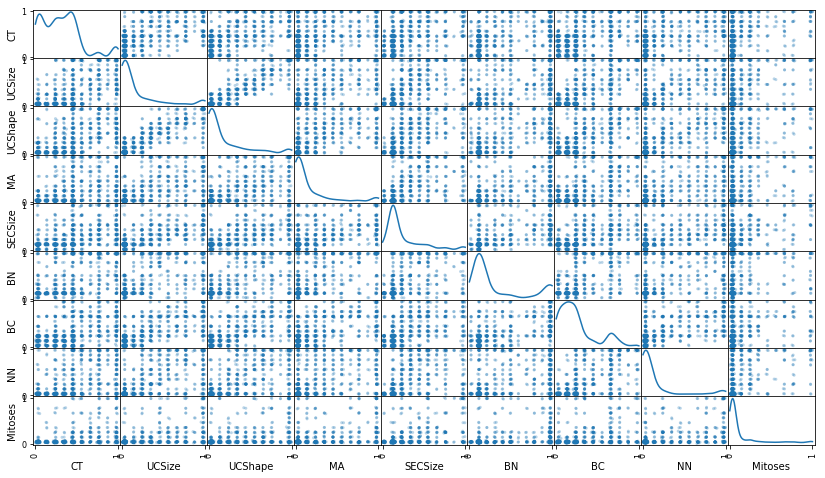

In [782]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

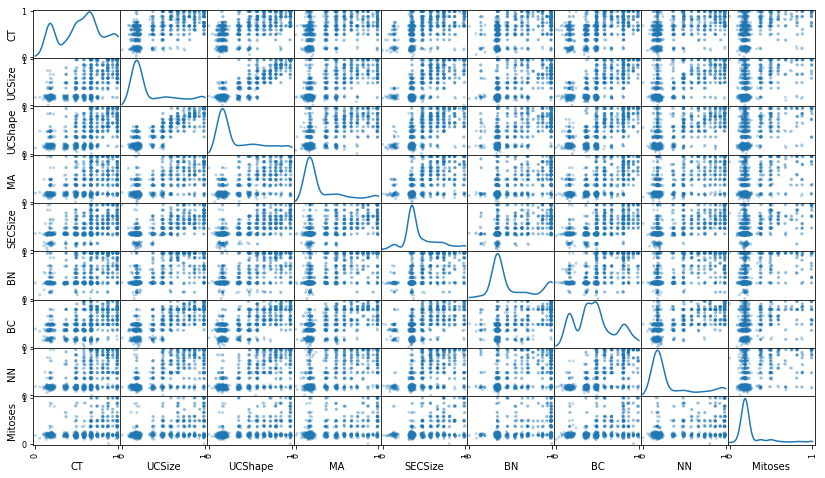

In [783]:
# Scale the data using squared root transformation
sqrt_features = features.copy()

for feature_name in sqrt_features.columns:
    sqrt_features[feature_name] = np.sqrt(sqrt_features[feature_name]) 
    
# sqrt_features = scaler.fit_transform(sqrt_features)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(pd.DataFrame(sqrt_features), alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# convert numpy ndarray into Pandas DataFrame
features = pd.DataFrame(sqrt_features)

#### Split dataset into training and testing datasets

In [784]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size=0.25, random_state=42)

#### Reindex 

In [785]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Convert Pandas DataFrame to Numpy ndarray
* This conversion is necessary because Pandas DataFrame is not consist with Keras API.

In [786]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

#### Classify dataset using Random Forest Classifier

In [787]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

score = rfc.score(X_test, y_test)
print("score = ", score)

('score = ', 0.98571428571428577)


#### Deep learning

In [788]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
import keras
import keras.utils
from keras import utils as np_utils

#### Define NN Architecture
* add Dropout(0.5) does not produce noticable performance in accuracy once the epochs >= 500.

In [789]:
model = Sequential()

#Define your architecture.
model.add(Dense(9, activation='relu', input_dim=9))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu', input_shape=(9,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', input_shape=(5,)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 9)                 90        
_________________________________________________________________
dropout_66 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_115 (Dense)            (None, 5)                 50        
_________________________________________________________________
dropout_67 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


#### Compile NN Model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['binary_accuracy'])

#### Train NN Model

In [ ]:
model.fit(X_train, y_train, epochs=500, batch_size=16) # (500, 16) = 0.974286, 32 - 0.968571

Epoch 1/500
1048/1048 [==============================] - 0s - loss: 0.6960 - binary_accuracy: 0.5162     
Epoch 2/500
1048/1048 [==============================] - 0s - loss: 0.6670 - binary_accuracy: 0.6441     - ETA: 0s - loss: 0.6735 - binary_accuracy: 0.5
Epoch 3/500
1048/1048 [==============================] - 0s - loss: 0.6481 - binary_accuracy: 0.7137     
Epoch 4/500
1048/1048 [==============================] - 0s - loss: 0.6361 - binary_accuracy: 0.7118     
Epoch 5/500
1048/1048 [==============================] - 0s - loss: 0.6212 - binary_accuracy: 0.7634     
Epoch 6/500
1048/1048 [==============================] - 0s - loss: 0.6169 - binary_accuracy: 0.7634     
Epoch 7/500
1048/1048 [==============================] - 0s - loss: 0.5966 - binary_accuracy: 0.7786     
Epoch 8/500
1048/1048 [==============================] - 0s - loss: 0.5802 - binary_accuracy: 0.8006     
Epoch 9/500
1048/1048 [==============================] - 0s - loss: 0.5697 - binary_accuracy: 0.7920     

1048/1048 [==============================] - 0s - loss: 0.3625 - binary_accuracy: 0.8387     
Epoch 78/500
1048/1048 [==============================] - 0s - loss: 0.3577 - binary_accuracy: 0.8521     
Epoch 79/500
1048/1048 [==============================] - 0s - loss: 0.3267 - binary_accuracy: 0.8531     
Epoch 80/500
1048/1048 [==============================] - 0s - loss: 0.3337 - binary_accuracy: 0.8616     
Epoch 81/500
1048/1048 [==============================] - 0s - loss: 0.3579 - binary_accuracy: 0.8502     
Epoch 82/500
1048/1048 [==============================] - 0s - loss: 0.3490 - binary_accuracy: 0.8473     
Epoch 83/500
1048/1048 [==============================] - 0s - loss: 0.3384 - binary_accuracy: 0.8645     
Epoch 84/500
1048/1048 [==============================] - 0s - loss: 0.3349 - binary_accuracy: 0.8569     
Epoch 85/500
1048/1048 [==============================] - 0s - loss: 0.3581 - binary_accuracy: 0.8359     
Epoch 86/500
1048/1048 [==========================

1048/1048 [==============================] - 0s - loss: 0.2491 - binary_accuracy: 0.8989     
Epoch 154/500
1048/1048 [==============================] - 0s - loss: 0.2711 - binary_accuracy: 0.8998     
Epoch 155/500
1048/1048 [==============================] - 0s - loss: 0.2421 - binary_accuracy: 0.9122     
Epoch 156/500
1048/1048 [==============================] - 0s - loss: 0.2771 - binary_accuracy: 0.8874     
Epoch 157/500
1048/1048 [==============================] - 0s - loss: 0.2878 - binary_accuracy: 0.8788     
Epoch 158/500
1048/1048 [==============================] - 0s - loss: 0.2379 - binary_accuracy: 0.9160     
Epoch 159/500
1048/1048 [==============================] - 0s - loss: 0.2746 - binary_accuracy: 0.8912     
Epoch 160/500
1048/1048 [==============================] - 0s - loss: 0.2802 - binary_accuracy: 0.8950     
Epoch 161/500
1048/1048 [==============================] - 0s - loss: 0.2448 - binary_accuracy: 0.9017     
Epoch 162/500
1048/1048 [=================

1048/1048 [==============================] - 0s - loss: 0.2244 - binary_accuracy: 0.9084     
Epoch 228/500
1048/1048 [==============================] - 0s - loss: 0.2355 - binary_accuracy: 0.9132     
Epoch 229/500
1048/1048 [==============================] - 0s - loss: 0.2690 - binary_accuracy: 0.8998     
Epoch 230/500
1048/1048 [==============================] - 0s - loss: 0.2293 - binary_accuracy: 0.9094     
Epoch 231/500
1048/1048 [==============================] - 0s - loss: 0.2621 - binary_accuracy: 0.9027     
Epoch 232/500
1048/1048 [==============================] - 0s - loss: 0.2579 - binary_accuracy: 0.8931     - ETA: 0s - loss: 0.2349 - binary_accuracy: 0.902
Epoch 233/500
1048/1048 [==============================] - 0s - loss: 0.2486 - binary_accuracy: 0.9179     
Epoch 234/500
1048/1048 [==============================] - 0s - loss: 0.2320 - binary_accuracy: 0.9113     
Epoch 235/500
1048/1048 [==============================] - 0s - loss: 0.2292 - binary_accuracy: 0.921

1048/1048 [==============================] - 0s - loss: 0.2459 - binary_accuracy: 0.8979     
Epoch 303/500
1048/1048 [==============================] - 0s - loss: 0.2294 - binary_accuracy: 0.9103     
Epoch 304/500
1048/1048 [==============================] - 0s - loss: 0.2489 - binary_accuracy: 0.8989     
Epoch 305/500
1048/1048 [==============================] - 0s - loss: 0.2495 - binary_accuracy: 0.8950     
Epoch 306/500
1048/1048 [==============================] - 0s - loss: 0.1967 - binary_accuracy: 0.9323     
Epoch 307/500
1048/1048 [==============================] - 0s - loss: 0.2361 - binary_accuracy: 0.9046     
Epoch 308/500
1048/1048 [==============================] - 0s - loss: 0.2505 - binary_accuracy: 0.8969     
Epoch 309/500
1048/1048 [==============================] - 0s - loss: 0.2530 - binary_accuracy: 0.9084     
Epoch 310/500
1048/1048 [==============================] - 0s - loss: 0.2574 - binary_accuracy: 0.8950     
Epoch 311/500
1048/1048 [=================

1048/1048 [==============================] - 0s - loss: 0.2280 - binary_accuracy: 0.9055     
Epoch 378/500
1048/1048 [==============================] - 0s - loss: 0.2565 - binary_accuracy: 0.8922     
Epoch 379/500
1048/1048 [==============================] - 0s - loss: 0.2418 - binary_accuracy: 0.8989     
Epoch 380/500
1048/1048 [==============================] - 0s - loss: 0.2307 - binary_accuracy: 0.9103     
Epoch 381/500
1048/1048 [==============================] - 0s - loss: 0.2288 - binary_accuracy: 0.9103     
Epoch 382/500
1048/1048 [==============================] - 0s - loss: 0.2803 - binary_accuracy: 0.8941     
Epoch 383/500
1048/1048 [==============================] - 0s - loss: 0.2668 - binary_accuracy: 0.8922     
Epoch 384/500
1048/1048 [==============================] - 0s - loss: 0.2426 - binary_accuracy: 0.9046     
Epoch 385/500
1048/1048 [==============================] - 0s - loss: 0.2393 - binary_accuracy: 0.9055     
Epoch 386/500
1048/1048 [=================

1048/1048 [==============================] - 0s - loss: 0.2257 - binary_accuracy: 0.9179     
Epoch 453/500
1048/1048 [==============================] - 0s - loss: 0.2272 - binary_accuracy: 0.9122     
Epoch 454/500
1048/1048 [==============================] - 0s - loss: 0.2284 - binary_accuracy: 0.9036     
Epoch 455/500
1048/1048 [==============================] - 0s - loss: 0.2409 - binary_accuracy: 0.9036     
Epoch 456/500
1048/1048 [==============================] - 0s - loss: 0.2284 - binary_accuracy: 0.9055     
Epoch 457/500
1048/1048 [==============================] - 0s - loss: 0.2068 - binary_accuracy: 0.9189     
Epoch 458/500
1048/1048 [==============================] - 0s - loss: 0.2358 - binary_accuracy: 0.9017     
Epoch 459/500
1048/1048 [==============================] - 0s - loss: 0.2414 - binary_accuracy: 0.9094     
Epoch 460/500
1048/1048 [==============================] - 0s - loss: 0.2451 - binary_accuracy: 0.9036     
Epoch 461/500
1048/1048 [=================

#### Test NN Model

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=16) # 16 - 0.974286, 32 - 0.968571
print("score = ", score)

#### Draw ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

y_pred = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()